## Set-up

In [1]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image


device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
    
    
data_dir = 'notebooks/videos/MRI515_T2'
video_dir = os.path.join(data_dir, 'img_in_jpg_L4L5_renamed')
label_jpg_dir = 'label_in_png_L4L5_renamed'


prompt_idx = [0]
prompt_idx = [0,1]
prompt_idx = [0,1,2]



### Loading the SAM 2 video predictor

In [2]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [3]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

#### Select an example video

We assume that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`.

For your custom videos, you can extract their JPEG frames using ffmpeg (https://ffmpeg.org/) as follows:
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
where `-q:v` generates high-quality JPEG frames and `-start_number 0` asks ffmpeg to start the JPEG file from `00000.jpg`.

['00000.jpg', '00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg'] ->->->->-> ['00406.jpg', '00407.jpg', '00408.jpg', '00409.jpg', '00410.jpg']


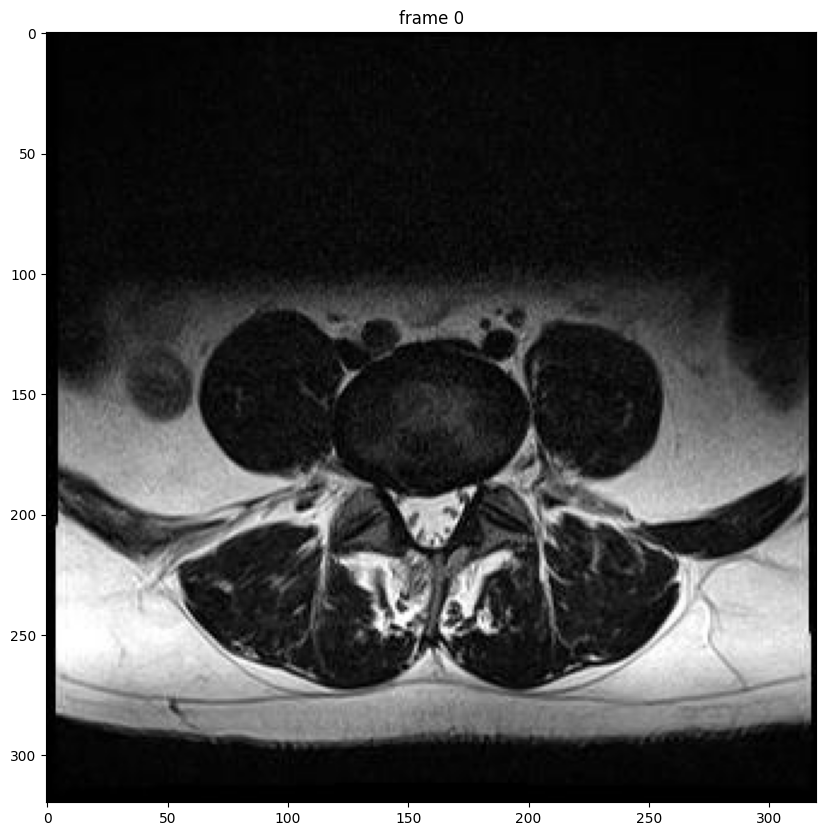

In [4]:
# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(10, 10))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])), cmap='grey')
print(frame_names[:5], '->'*5,frame_names[-5:])


In [5]:
inference_state = predictor.init_state(video_path=video_dir)
predictor.reset_state(inference_state)

frame loading (JPEG): 100%|███████████████████| 411/411 [00:06<00:00, 59.09it/s]


In [6]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define class ranges
class_ranges = {    1: (30, 70),     2: (80, 120),     3: (130, 170),      4: (180, 220) }

# Process each prompt index
for idx in prompt_idx:
    img_path = os.path.join(video_dir, frame_names[idx])
    seg_path = os.path.join(data_dir, label_jpg_dir, str(idx).zfill(5) + '.png')

    print(idx, f"Image path: {img_path}")
    print(idx, f"Segmentation path: {seg_path}")

    try:
        # Read the image and convert it to grayscale
        seg_image = Image.open(seg_path).convert("L")
        img_image = Image.open(img_path).convert("L")  # Read the original image as the background
    except Exception as e:
        print(f"Error reading image {idx}: {e}")
        continue

    # Convert to NumPy array
    seg_array = np.array(seg_image)
    img_array = np.array(img_image)

    # Create class masks
    class_masks = {}
    for class_id, (low, high) in class_ranges.items():
        mask = (seg_array >= low) & (seg_array <= high)
        class_mask = np.zeros_like(seg_array, dtype=np.uint8)
        class_mask[mask] = 1

        # Resize to match the original image
        class_mask = np.array(Image.fromarray(class_mask).resize(img_array.shape[::-1], Image.NEAREST))
        class_masks[class_id] = class_mask

    ann_frame_idx = idx  # Frame index for annotation

    # Add masks one by one
    for ann_obj_id, class_mask in class_masks.items():
        print(f"Processed frame {idx} with {ann_obj_id} objid.")

        _, out_obj_ids, out_mask_logits = predictor.add_new_mask(
            inference_state=inference_state,
            frame_idx=ann_frame_idx,
            obj_id=ann_obj_id,
            mask=class_mask
        )

    print(f"Processed frame {idx} with {len(class_masks)} classes.")


0 Image path: notebooks/videos/MRI515_T2/img_in_jpg_L4L5_renamed/00000.jpg
0 Segmentation path: notebooks/videos/MRI515_T2/label_in_png_L4L5_renamed/00000.png
Processed frame 0 with 1 objid.
Processed frame 0 with 2 objid.
Processed frame 0 with 3 objid.
Processed frame 0 with 4 objid.
Processed frame 0 with 4 classes.
1 Image path: notebooks/videos/MRI515_T2/img_in_jpg_L4L5_renamed/00001.jpg
1 Segmentation path: notebooks/videos/MRI515_T2/label_in_png_L4L5_renamed/00001.png
Processed frame 1 with 1 objid.
Processed frame 1 with 2 objid.
Processed frame 1 with 3 objid.
Processed frame 1 with 4 objid.
Processed frame 1 with 4 classes.
2 Image path: notebooks/videos/MRI515_T2/img_in_jpg_L4L5_renamed/00002.jpg
2 Segmentation path: notebooks/videos/MRI515_T2/label_in_png_L4L5_renamed/00002.png
Processed frame 2 with 1 objid.
Processed frame 2 with 2 objid.
Processed frame 2 with 3 objid.
Processed frame 2 with 4 objid.
Processed frame 2 with 4 classes.


In [7]:
iou_score_return = True
max_frame_num_to_track = len(frame_names)

video_segments, video_segments_nolap, iou_score = {}, {}, {}

for out in predictor.propagate_in_video(inference_state, 
                                        iou_score_return=iou_score_return, 
                                        max_frame_num_to_track=max_frame_num_to_track):
    out_frame_idx, out_obj_ids, out_mask_logits = out[:3]
    ious = out[3] if iou_score_return else None
    
    video_segments[out_frame_idx] = {
        obj_id: (out_mask_logits[i] > 0.0).cpu().numpy() for i, obj_id in enumerate(out_obj_ids)
    }
    
    if iou_score_return:
        iou_score[out_frame_idx] = {obj_id: ious[i] for i, obj_id in enumerate(out_obj_ids)}
        
        
    # Resolve overlaps
      
    frame_masks = {
        obj_id: (out_mask_logits[i] > 0.0).cpu().numpy() * out_mask_logits[i].cpu().numpy()
        for i, obj_id in enumerate(out_obj_ids)
    }  

    
    stacked_masks = np.stack([frame_masks[obj_id] > 0 for obj_id in frame_masks], axis=0)
    stacked_logits = np.stack([frame_masks[obj_id] for obj_id in frame_masks], axis=0)
    max_logits_indices = np.argmax(stacked_logits, axis=0)
    
    video_segments_nolap[out_frame_idx] = {
        obj_id: (max_logits_indices == i).astype(np.uint8) & stacked_masks[i]
        for i, obj_id in enumerate(frame_masks)
    }


propagate in video: 100%|█████████████████████| 411/411 [09:55<00:00,  1.45s/it]


In [8]:
import os
import torch
import pandas as pd

vis_frame_stride = 1

# Define CSV file name
csv_write_path = os.path.join(data_dir, "iou_results.csv")

# Compute and store IoU results
results = []
for f_idx in range(0, max_frame_num_to_track, vis_frame_stride):
    for o_id, iou in iou_score[f_idx].items():
        max_iou = torch.max(iou).item()
        results.append({"frame_idx": f_idx, "obj_id": o_id, "iou": max_iou})

# Save results and convert format
results_df = pd.DataFrame(results)

# Convert to wide format and print
wide_df = results_df.pivot(index="frame_idx", columns="obj_id", values="iou")
wide_df.columns = [f"iou_id{col}" for col in wide_df.columns]
wide_df["iou_sum"] = wide_df.sum(axis=1)

wide_df.to_csv(csv_write_path, index=True)
print(f"Data successfully written to {csv_write_path}")

print(wide_df.reset_index())


数据已成功写入 notebooks/videos/MRI515_T2/iou_results.csv
     frame_idx   iou_id1   iou_id2   iou_id3   iou_id4   iou_sum
0            0  1.000000  1.000000  1.000000  1.000000  4.000000
1            1  1.000000  1.000000  1.000000  1.000000  4.000000
2            2  1.000000  1.000000  1.000000  1.000000  4.000000
3            3  0.941817  0.854035  0.916014  0.921891  3.633757
4            4  0.906277  0.884688  0.924172  0.912738  3.627875
..         ...       ...       ...       ...       ...       ...
406        406  0.770657  0.803835  0.769401  0.703016  3.046910
407        407  0.881718  0.837527  0.913995  0.828414  3.461654
408        408  0.814403  0.896771  0.890348  0.765084  3.366606
409        409  0.893546  0.769146  0.887701  0.796948  3.347341
410        410  0.849721  0.766541  0.723614  0.594096  2.933973

[411 rows x 6 columns]


In [10]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    """
    Displays a segmentation mask on a given matplotlib axis.
    """
    
    if random_color:
        # Generate a random color with transparency
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        # Assign a color based on obj_id using the 'tab10' colormap
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])

    # Get mask dimensions
    h, w = mask.shape[-2:]

    # Apply color to mask
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    # Display the mask on the given axis
    ax.imshow(mask_image, cmap='gray')


In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count

# Datasets to be processed
video_segments_dict = {
    "yeslap": video_segments,
    "nolap": video_segments_nolap
}

# Ensure directories exist
for key in video_segments_dict.keys():
    os.makedirs(os.path.join(data_dir, f"SAM2_seg_mask_{key}"), exist_ok=True)
    os.makedirs(os.path.join(data_dir, f"SAM2_seg_plot_{key}"), exist_ok=True)

# Function to process a single frame
def process_frame(args):
    key, idx, video_segments_todo = args
    seg_dir = os.path.join(data_dir, f"SAM2_seg_mask_{key}")
    vis_dir = os.path.join(data_dir, f"SAM2_seg_plot_{key}")

    frame_path = os.path.join(video_dir, frame_names[idx])
    frame_image = Image.open(frame_path)
    combined_mask = None

    for obj_id, mask in video_segments_todo[idx].items():
        mask = np.squeeze(mask) if mask.ndim > 2 else mask
        scaled_mask = mask * (obj_id * 50)  # Assign different grayscale values to objects

        # Save individual object mask
        Image.fromarray(scaled_mask.astype("uint8")).save(
            os.path.join(seg_dir, f"frame_{idx}_obj_{obj_id}.png"), "PNG"
        )

        # Generate combined mask
        combined_mask = np.maximum(combined_mask, scaled_mask) if combined_mask is not None else scaled_mask

    # Save combined mask
    if combined_mask is not None:
        Image.fromarray(combined_mask.astype("uint8")).save(
            os.path.join(seg_dir, f"frame_{idx}_combined.png"), "PNG"
        )

    # Visualization
    plt.figure(figsize=(6, 4))
    plt.title(f"Frame {idx} ({key})")
    plt.imshow(frame_image, cmap='gray')
    for obj_id, mask in video_segments_todo[idx].items():
        show_mask(np.squeeze(mask) if mask.ndim > 2 else mask, plt.gca(), obj_id=obj_id)

    plt.savefig(os.path.join(vis_dir, f"frame_{idx}_visualization.png"), format="png", dpi=300)
    plt.close()

    print(f"Processed frame {idx} for {key}")

# Multi-processing for acceleration
if __name__ == '__main__':
    num_workers = min(8, cpu_count())  # Use up to 8 CPU cores

    with Pool(num_workers) as pool:
        tasks = []
        for key, video_segments_todo in video_segments_dict.items():
            for idx in range(0, len(frame_names), vis_frame_stride):
                tasks.append((key, idx, video_segments_todo))

        pool.map(process_frame, tasks)  # Process frames in parallel


In [12]:
import multiprocessing
print("Number of CPU cores:", multiprocessing.cpu_count())


CPU 核心数: 12
